# Hyperparemeter optimization of networks to predict wpm


## Set up


In [1]:
# Building on the basic pytorch model in nn-predict.ipynb, develop ML pipeline with 
# hyperparameter optimization
# See https://appsilon.com/pytorch-neural-network-tutorial/ for a simple example

# Set up to use local modules
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, module_path)

In [2]:
import time

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
from sklearn.metrics import root_mean_squared_error


from src import process
from src import models

# Load the CSV file results.csv into a dataframe and add some processed columns
df = process.load_processed_results()
# display(df.head())
# display(df.tail())

## Train network


In [3]:
# Prepare data

# Include trial types above a certain threshold of occurances
min_trial_count = 100
combined_id_value_counts = df["combined_id"].value_counts()
combined_id_value_counts = combined_id_value_counts[
    combined_id_value_counts >= min_trial_count
]

valid_trial_ids = combined_id_value_counts.index.tolist()
feature_cols = ["combined_id", "acc", "trial_num", "trial_type_num"]
target_col = ["wpm"]

X_df = df.loc[
    df["combined_id"].isin(valid_trial_ids),
    feature_cols,
]
Y_df = df[df["combined_id"].isin(valid_trial_ids)][target_col]

# Convert X_df['combined_id'] to a 1-hot encoding
X_df = pd.get_dummies(X_df, columns=["combined_id"]).astype(int)

display(X_df.head())
display(Y_df.head())

,acc,trial_num,trial_type_num,combined_id_2,combined_id_17,combined_id_25,combined_id_29,combined_id_34
5,91,6,1,1,0,0,0,0
6,95,7,2,1,0,0,0,0
7,93,8,3,1,0,0,0,0
8,93,9,4,1,0,0,0,0
9,90,10,5,1,0,0,0,0


,wpm
5,52.39
6,64.39
7,57.79
8,58.39
9,53.79


In [4]:
# Parameters
params = models.get_default_params()

seed = 42
torch.manual_seed(seed)

print(f"Using device: {params.device}")

# Set up data
X = torch.tensor(X_df.values, dtype=torch.float)
y = torch.tensor(Y_df.values, dtype=torch.float)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=params.train_size, random_state=seed
)
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, shuffle=True, batch_size=params.batch_size)
test_loader = DataLoader(test_data, batch_size=len(test_data.tensors[0]))
X_train, y_train = X_train.to(params.device), y_train.to(params.device)
X_test, y_test = X_test.to(params.device), y_test.to(params.device)

Using device: cuda


In [5]:
# Create model
input_n = X.shape[1]
output_n = y.shape[1]
base_model = models.MLPcondensed(input_n, params.n_hidden_units, output_n)
base_model = base_model.to(params.device)

# Set up for training
optimizer = torch.optim.Adam(
    params=base_model.parameters(), lr=params.lr, weight_decay=params.weight_decay
)
scheduler = StepLR(optimizer, step_size=1, gamma=params.gamma)
loss_function = nn.MSELoss()

# Train model
train_loss, test_loss = models.train_and_evaluate(
    base_model, train_loader, test_loader, scheduler, optimizer, loss_function, params
)

Epoch [ 100/1000], Train loss: 237.7150, Test loss: 245.9892, Run Time: 01.55
Epoch [ 200/1000], Train loss: 162.9344, Test loss: 164.8875, Run Time: 02.88
Epoch [ 300/1000], Train loss: 57.5367, Test loss: 71.4987, Run Time: 04.08
Epoch [ 400/1000], Train loss: 39.1989, Test loss: 48.6654, Run Time: 05.38
Epoch [ 500/1000], Train loss: 30.1039, Test loss: 39.1998, Run Time: 06.56
Epoch [ 600/1000], Train loss: 29.3631, Test loss: 34.6004, Run Time: 07.78
Epoch [ 700/1000], Train loss: 25.5268, Test loss: 30.6704, Run Time: 09.01
Epoch [ 800/1000], Train loss: 21.6441, Test loss: 27.6060, Run Time: 10.30
Epoch [ 900/1000], Train loss: 19.9019, Test loss: 26.7037, Run Time: 11.50
Epoch [1000/1000], Train loss: 20.1560, Test loss: 24.0866, Run Time: 12.71


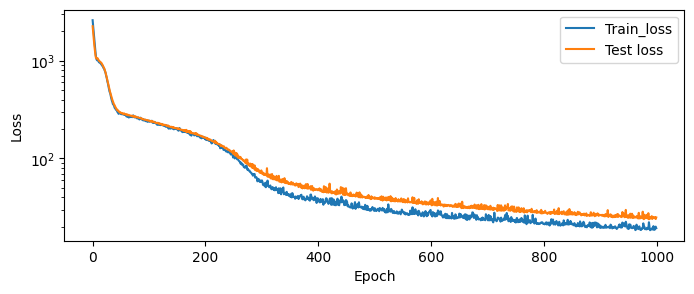

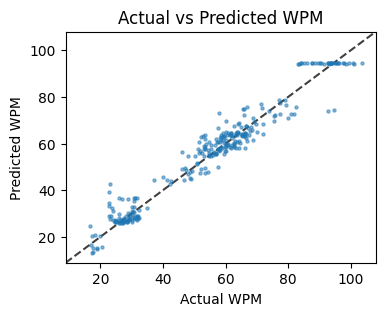

In [6]:
# Plot loss
fig = plt.figure(figsize=(8, 3))
plt.plot(train_loss, label="Train_loss")
plt.plot(test_loss, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.show()

# Plot actual vs predicted wpm
y_pred = base_model(X_test)
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
ax.scatter(y_test.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), alpha=0.5, s=5)
ax.set_xlabel("Actual WPM")
ax.set_ylabel("Predicted WPM")
ax.set_title("Actual vs Predicted WPM")
# Ref line, without affecting axis limits
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, "k--", alpha=0.75, zorder=0)
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## Hyperopt


In [7]:
# Define the space over which hyperopt will search for optimal hyperparameters.

# best loss: 16.306495666503906
# Best hyperparameters: {'gamma': 0.9960181162722727, 'learning_rate': 0.007269113318457658, 'weight_decay': 0.001119076053891545}
space = {
    # loguniform
    "learning_rate": hp.loguniform("learning_rate", np.log(1e-5), np.log(1e-2)),
    "weight_decay": hp.loguniform("weight_decay", np.log(1e-5), np.log(1e-1)),
    "gamma": hp.uniform("gamma", 0.9, 0.999),
    # Fixed
    "log_interval": np.inf,
}

# best loss: 14.207015037536621
# Best hyperparameters: {'gamma': 0.9936028171578175, 'learning_rate': 0.04978030842407764, 'weight_decay': 0.0017546369177781098}
space = {
    # loguniform
    "learning_rate": hp.loguniform("learning_rate", np.log(0.0007), np.log(0.07)),
    "weight_decay": hp.loguniform("weight_decay", np.log(0.0001), np.log(0.01)),
    "gamma": hp.uniform("gamma", 0.99, 0.9999),
    # Fixed
    "log_interval": np.inf,
}

# Final loss (MSE): 10.72558880
# Best optimized hyperparameters:
# {'batch_size': 4096, 'gamma': 0.9998522974475944, 'learning_rate': 0.003966298895429614, 'log_interval': inf, 'model': 'MLPcondensed', 'n_epochs': 10000, 'n_hidden_units': 64, 'n_layers': 1, 'weight_decay': 0.0023468805643251044}
space_large = {
    # loguniform
    "learning_rate": hp.loguniform("learning_rate", np.log(0.0005), np.log(0.9)),
    "weight_decay": hp.loguniform("weight_decay", np.log(0.00001), np.log(0.1)),
    "gamma": hp.uniform("gamma", 0.95, 0.99999),
    "n_hidden_units": hp.choice("n_hidden_units", [16, 64, 256, 1024]),
    "n_epochs": hp.choice("n_epochs", [1000, 10000]),
    "n_layers": hp.choice("n_layers", [1, 2, 3, 4, 5]),
    # Fixed
    # "n_epochs": 1000,
    "log_interval": np.inf,
    "batch_size": 4096,
    "model": "MLPcondensed",
}

In [8]:
# Define the hyperopt objective.
def hyperparameter_tuning(space, verbose=True):
    # Set up the parameters
    # TODO automatically loop through the space and set the parameters
    # Variable
    params.lr = space["learning_rate"]
    params.weight_decay = space["weight_decay"]
    params.gamma = space["gamma"]
    params.n_hidden_units = space["n_hidden_units"]
    params.nLayers = space["n_layers"]
    # Fixed
    params.log_interval = space["log_interval"]
    params.n_epochs = space["n_epochs"]
    params.batch_size = space["batch_size"]

    # Create the model
    input_n = X.shape[1]
    output_n = y.shape[1]
    if space["model"] == "MLPcondensed":
        model = models.MLPcondensed(input_n, params.n_hidden_units, output_n)
    elif space["model"] == "MLPCondensedVariable":
        model = models.MLPCondensedVariable(
            input_n, params.n_hidden_units, output_n, params.nLayers
        )
    else:
        raise ValueError("Invalid model type")
    model = model.to(params.device)

    # Set up for training
    optimizer = torch.optim.Adam(
        params=model.parameters(), lr=params.lr, weight_decay=params.weight_decay
    )
    scheduler = StepLR(optimizer, step_size=1, gamma=params.gamma)
    loss_function = nn.MSELoss()

    # Train model
    _, _ = models.train_and_evaluate(
        model, train_loader, test_loader, scheduler, optimizer, loss_function, params
    )
    model.eval()
    y_pred = model(X_test)
    loss = loss_function(y_pred, y_test)

    if verbose:
        print(f"Using varied parameters: {space}")
        print(f"                   Loss: {loss}")
    return {"loss": loss, "status": STATUS_OK, "model": model}

In [9]:
# Run trials.
trials = Trials()
best = fmin(
    fn=hyperparameter_tuning,
    space=space,
    algo=tpe.suggest,
    max_evals=300,  # 25
    trials=trials,
)
print(f"Best hyperparameters: {best}")

  0%|          | 0/300 [00:00<?, ?trial/s, best loss=?]

Using varied parameters: {'batch_size': 4096, 'gamma': 0.9577058211509634, 'learning_rate': 0.006992202765502295, 'log_interval': inf, 'model': 'MLPcondensed', 'n_epochs': 1000, 'n_hidden_units': 1024, 'n_layers': 2, 'weight_decay': 2.4189291192238137e-05}
                   Loss: 220.7882537841797             
Using varied parameters: {'batch_size': 4096, 'gamma': 0.9961245079666395, 'learning_rate': 0.0021045638682948924, 'log_interval': inf, 'model': 'MLPcondensed', 'n_epochs': 10000, 'n_hidden_units': 64, 'n_layers': 4, 'weight_decay': 0.0011357647973046152}
                   Loss: 17.165843963623047                                       
Using varied parameters: {'batch_size': 4096, 'gamma': 0.9973391064762177, 'learning_rate': 0.005513733700607129, 'log_interval': inf, 'model': 'MLPcondensed', 'n_epochs': 10000, 'n_hidden_units': 1024, 'n_layers': 3, 'weight_decay': 0.00046157917307910996}
                   Loss: 12.84381103515625                                         
Using 

In [10]:
# Save all the trials to a file with name append datetime
# Save the trials object
import pickle

trial_filename = f"trials_{time.strftime('%Y%m%d-%H%M%S')}.pkl"
print(trial_filename)
with open(trial_filename, "wb") as f:
    pickle.dump(trials, f)

# TODO fix save location, add option to load and plot, maybe in another notebook

trials_20240218-064120.pkl


best loss: 10.72558879852295


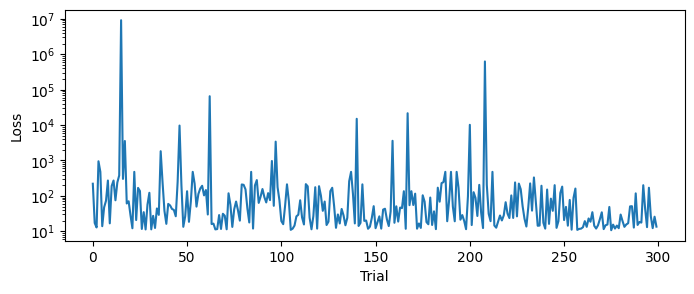

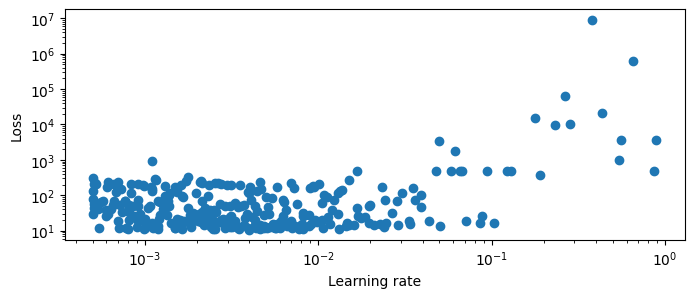

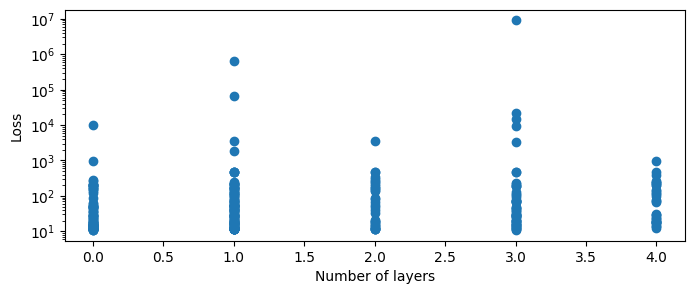

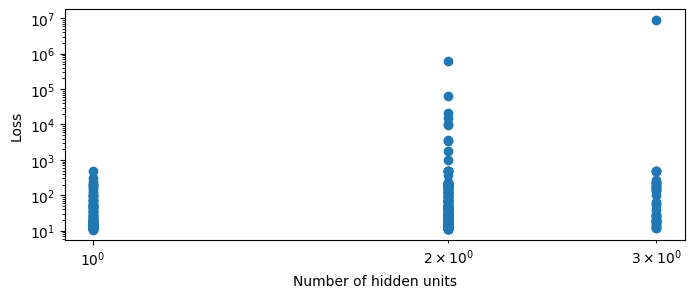

In [14]:
# Plot basic results from Trials
# Extract the losses from the trials object
losses = [x["result"]["loss"] for x in trials.trials]
learning_rates = [x["misc"]["vals"]["learning_rate"] for x in trials.trials]
n_layers = [x["misc"]["vals"]["n_layers"] for x in trials.trials]
n_units = [x["misc"]["vals"]["n_hidden_units"] for x in trials.trials]
best_loss = np.min(losses)
print(f"best loss: {best_loss}")
# Plot loss across trials
fig = plt.figure(figsize=(8, 3))
plt.plot(losses)
plt.xlabel("Trial")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()
# Plot losses as function of learning rate
fig = plt.figure(figsize=(8, 3))
plt.scatter(learning_rates, losses)
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.yscale("log")
plt.xscale("log")
plt.show()
# Plot losses as function of number of layers
fig = plt.figure(figsize=(8, 3))
plt.scatter(n_layers, losses)
plt.xlabel("Number of layers")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()
# Plot losses as function of number of hidden units
fig = plt.figure(figsize=(8, 3))
plt.scatter(n_units, losses)
plt.xlabel("Number of hidden units")
plt.ylabel("Loss")
plt.yscale("log")
plt.xscale("log")
plt.show()

In [12]:
# Create instace of best model.
best_model = trials.results[np.argmin([r["loss"] for r in trials.results])]["model"]

# Examine model hyperparameters
best_model_loss = trials.results[np.argmin([r["loss"] for r in trials.results])]["loss"]
print(f"Final loss (MSE): {best_model_loss:.8f}")
print(f"Best optimized hyperparameters:\n{space_eval(space, best)}")

Final loss (MSE): 10.72558880
Best optimized hyperparameters:
{'batch_size': 4096, 'gamma': 0.9998522974475944, 'learning_rate': 0.003966298895429614, 'log_interval': inf, 'model': 'MLPcondensed', 'n_epochs': 10000, 'n_hidden_units': 64, 'n_layers': 1, 'weight_decay': 0.0023468805643251044}


In [13]:
best_model.eval()
best_model_score = root_mean_squared_error(
    y_test.cpu(), best_model(X_test).cpu().detach().numpy()
)
print("Best Model RMSE:", best_model_score)
#
base_model_score = root_mean_squared_error(
    y_test.cpu(), base_model(X_test).cpu().detach().numpy()
)
print("Base model RMSE:", base_model_score)
# MSE from guessing the mean of the training set
mean_model_score = root_mean_squared_error(
    y_test.cpu(), np.full(y_test.shape, np.mean(y_train.cpu().detach().numpy()))
)
print("Mean model RMSE:", mean_model_score)

Best Model RMSE: 3.2749944
Base model RMSE: 5.00214
Mean model RMSE: 21.851515
